In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
%%capture
!pip install transformers datasets
!pip install transformers
!pip install transformers[torch]
!pip install transformers[tf-cpu]
!pip install transformers[flax]
!pip install torch
!pip install tensorflow
!pip install evaluate

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, IntervalStrategy, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

%matplotlib inline
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Path

In [5]:
TRAIN_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/train.csv")  
VAL_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/dev.csv")
TEST_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/test.csv")
# VAL_PRED_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/dev-submission-79.4.csv")
TEST_PRED_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/80.01-ensemble_on_ensemble_on_mv-79.28_79.35_79.91.csv")

# 
LABEL1_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/70.519-traintrain_back_transtest_pred_7_mv_combined.csv")  
LABEL2_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/70.521-traintrain_back_transval_back_transmodel_annotmodel_annot_back_trans.csv")  
LABEL3_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/71.136-traintrain_back_transval_back_transmodel_annot.csv")  
LABEL6_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/71.326-traintrain_back_trans.csv")  
LABEL7_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/71.977-traintrain_back_transval_back_trans.csv")  

MV_PATH = Path("/kaggle/input/vitd-violence-inciting-text-detection/7majority_voting.csv")

# # Training output directory
OUTPUT_DIR = Path("./output/VITD-Models/banglaBert")

MODEL_NAME = 'csebuetnlp/banglabert'

## Imports

In [90]:
train_df = pd.read_csv(TRAIN_PATH) # train set
val_df = pd.read_csv(VAL_PATH) # validation set

In [153]:
# add val_data to train
# train_df = pd.concat([train_df, val_df], ignore_index=True)

In [91]:
# add predicted test data to train
# val_pred_df = pd.read_csv(VAL_PRED_PATH)
test_pred_df = pd.read_csv(TEST_PRED_PATH)
# train_df = pd.concat([train_df, test_pred_df[(test_pred_df["label"] == 1) | (test_pred_df["label"] == 2)]], ignore_index=True)
train_df = pd.concat([train_df, test_pred_df[(test_pred_df["label"] == 2)]], ignore_index=True)

# ------------------------------------

# Specify the percentage of rows to randomly select and concatenate
percentage_to_concat = 0.7  # 10% of the rows

# Filter test_pred_df to rows where label is 1
label_1_rows = test_pred_df[test_pred_df["label"] == 1]

# Calculate the number of rows to select based on the percentage
num_rows_to_concat = int(len(label_1_rows) * percentage_to_concat)

# Randomly select rows from label_1_rows
selected_rows = label_1_rows.sample(n=num_rows_to_concat, random_state=42)

# Concatenate the selected rows with train_df
train_df = pd.concat([train_df, selected_rows], ignore_index=True)

# ------------------------------------

# Specify the percentage of rows to randomly select and concatenate
percentage_to_concat = 0.3  # 10% of the rows

# Filter test_pred_df to rows where label is 1
label_0_rows = test_pred_df[test_pred_df["label"] == 0]

# Calculate the number of rows to select based on the percentage
num_rows_to_concat = int(len(label_0_rows) * percentage_to_concat)

# Randomly select rows from label_1_rows
selected_rows = label_0_rows.sample(n=num_rows_to_concat, random_state=42)

# Concatenate the selected rows with train_df
train_df = pd.concat([train_df, selected_rows], ignore_index=True)


## EDA

In [92]:
print(len(train_df), len(val_df)) 

3714 1330


In [ ]:
train_df.columns

In [ ]:
pd.options.display.max_colwidth = 150
train_df.head() 

In [199]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3271 non-null   object
 1   label   3271 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.2+ KB


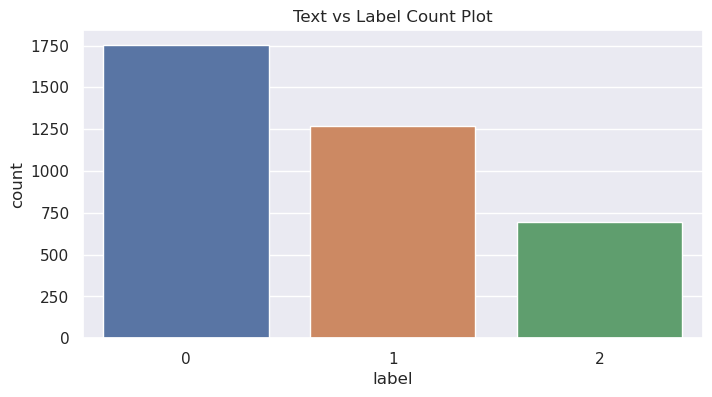

In [93]:
# train_df_label_count = train_df.groupby('label', as_index=False)['text'].nunique()
# train_df_label_count.rename(columns={'text':'text_count'}, inplace=True)

plt.figure(figsize=(8, 4))
plt.title("Text vs Label Count Plot")
sns.countplot(data=train_df, x='label')  
plt.show()

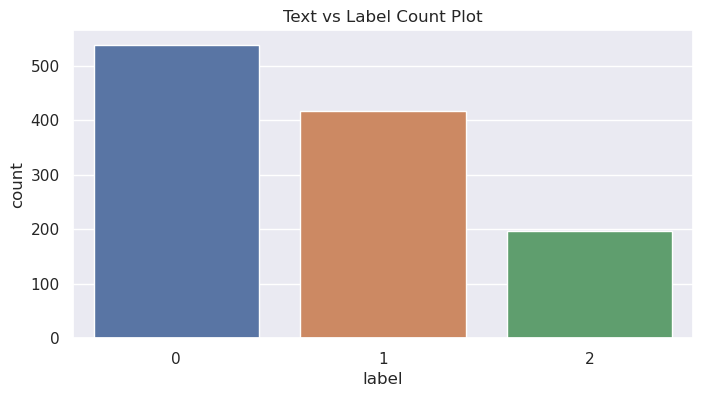

In [40]:
plt.figure(figsize=(8, 4))
plt.title("Text vs Label Count Plot")
sns.countplot(data=val_df, x='label')  
plt.show()

In [39]:
# preprocess val set
# Count the number of rows where 'label' is 0
num_zeros = (val_df['label'] == 0).sum()

print(num_zeros)
# Determine the number of rows to drop (half of the 'label' 0 count)
rows_to_drop = num_zeros // 4

# Filter the DataFrame to get the rows with 'label' equal to 0
label_zero_rows = val_df[val_df['label'] == 0]

# Drop half of the rows where 'label' is 0
val_df = val_df.drop(label_zero_rows.sample(rows_to_drop).index)

# reset index (recalibrate)
val_df.reset_index(drop=True, inplace=True)


717


In [25]:
train_df

,text,label
0,যে দেশে সন্ত্রাসরা দেশ চালায়সে দেশে শান্তি কিভ...,1
1,এই বিচার শেষ বিচার নয়।আসল বিচার হবে আল্লাহর আদ...,0
2,আরব দেশগুলোকে বলব ভারতের সাথে সব ব্যবসা বাণিজ্...,2
3,দেশটা সুস্থ নাই,0
4,আপনার কথা দুঃখ জনক আগে বিডিও থাকলে কেন ধরা হলন...,0
...,...,...
4637,যে মেয়েটি হিজাবের জন্য আল্লাহু আকবর বলতে পারে ...,0
4638,বোন মুচকানকে অংক্ষ ধন্যবাদ তার পাশে সকল মুসলিম...,0
4639,ইসলাম জিন্দাবাদআল্লাহ সকল মুসলিম দের উপর তুমি ...,0
4640,আমি ভূমিকম্প দেখেছিকিন্তু এই নারীর কন্ঠে 39আল্...,0


In [ ]:
# !pip install wordcloud 
# !pip install bnlp-toolkit   

In [ ]:
# import cv2
# import re
# from wordcloud import WordCloud
# from bnlp.corpus import stopwords, punctuations

### Data pre-processing

1. Class imbalance

In [ ]:
# # Count the number of rows where 'label' is 0
# num_zeros = (train_df['label'] == 1).sum()

# print(num_zeros)
# # Determine the number of rows to drop (half of the 'label' 0 count)
# rows_to_drop = num_zeros // 5

# # Filter the DataFrame to get the rows with 'label' equal to 0
# label_zero_rows = train_df[train_df['label'] == 1]

# # Drop half of the rows where 'label' is 0
# train_df = train_df.drop(label_zero_rows.sample(rows_to_drop).index)

# # reset index (recalibrate)
# train_df.reset_index(drop=True, inplace=True)


In [ ]:
# train_df

2. Punctuation and emoji Removal

In [26]:
#Base and Cleaning
import json
import requests
import emoji
import regex
import re
import string
from collections import Counter


#Natural Language Processing (NLP)
# import spacy
# import gensim
# from spacy.tokenizer import Tokenizer
# from wordcloud import STOPWORDS
# stopwords = set(STOPWORDS)

In [27]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.0 MB/s eta 0:00:00


In [28]:
import demoji
demoji.download_codes()

/tmp/ipykernel_28/2319952594.py:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [29]:
def remove_em(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [30]:
# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: remove_em(x)

In [31]:
def preprocess_text(text):
    text = call_emoji_free(text)
    text = remove_punctuations(text)
    return text

In [94]:
train_df["text"] = train_df["text"].apply(preprocess_text)

In [95]:
val_df["text"] = val_df["text"].apply(preprocess_text)

In [34]:
train_df

,text,label
0,যে দেশে সন্ত্রাসরা দেশ চালায়সে দেশে শান্তি কিভ...,1
1,এই বিচার শেষ বিচার নয়।আসল বিচার হবে আল্লাহর আদ...,0
2,আরব দেশগুলোকে বলব ভারতের সাথে সব ব্যবসা বাণিজ্...,2
3,দেশটা সুস্থ নাই,0
4,আপনার কথা দুঃখ জনক আগে বিডিও থাকলে কেন ধরা হলন...,0
...,...,...
4637,যে মেয়েটি হিজাবের জন্য আল্লাহু আকবর বলতে পারে ...,0
4638,বোন মুচকানকে অংক্ষ ধন্যবাদ তার পাশে সকল মুসলিম...,0
4639,ইসলাম জিন্দাবাদআল্লাহ সকল মুসলিম দের উপর তুমি ...,0
4640,আমি ভূমিকম্প দেখেছিকিন্তু এই নারীর কন্ঠে 39আল্...,0


In [ ]:
# stopwords.words("bengali")

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')


# def remove_bengali_stopwords(text):
#     words = nltk.word_tokenize(text)
#     filtered_words = [word for word in words if word.lower() not in stopwords.words('bengali')]
#     return ' '.join(filtered_words)

# train_df['text'] = train_df['text'].apply(remove_bengali_stopwords)

# Train

In [ ]:
# !pip uninstall jaxlibv-y
# !pip install -U jax jaxlib 

In [35]:
tokenizer_name = MODEL_NAME
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True) 

In [36]:
# from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(
#     train_df, test_size=0.25, stratify=train_df['label'], random_state=42)

In [157]:
# train_df = train_df.reset_index(drop=True)
# val_df = val_df.reset_index(drop=True)

In [39]:
val_df

,text,label
0,পৃথিবীর সব থেকে অবাসযোগ্য মৌলবাদী সাম্প্রদায়িক...,1
1,পাশের দেশের দাদারা কুরবানি নিষিদ্ধ করতে পারে।আ...,0
2,লীগ মানেই গজব। আর গুজব।,1
3,এখন সময় এসেছে সব টেলিভিশন কে বয়কট করার,2
4,আমাদের হিন্দু দের উপর নির্যাতনের কি হবে,0
...,...,...
1003,আলহামদুলিল্লাহ অনেক অনেক ধন্যবাদ ভাই জান তোমাক...,0
1004,হায়রে নির্বাচন নেতারা ভালোই থাকে মারা যায় সাধা...,0
1005,আশা রাখি ছাত্র ভাই ও বোনেরা ভালো কোন সিধান্তে ...,0
1006,ঈদের সময় দোকান বন্ধ রাখা উচিত,0


In [96]:
def pandaToList(dataset):
    text_list = []
    label_list = [] 
    for i in range(len(dataset['text'])): 
      text_list.append(dataset['text'][i]) 
      label_list.append(int(dataset['label'][i]))
    return text_list, label_list

train_texts, train_labels =  pandaToList(train_df)
val_texts, val_labels = pandaToList(val_df)  

In [97]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [98]:
class ViolenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ViolenceDataset(train_encodings, train_labels)
val_dataset = ViolenceDataset(val_encodings, val_labels)


In [47]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [99]:

training_args = TrainingArguments(  
   f"training_with_callbacks",
   evaluation_strategy = IntervalStrategy.STEPS, # "steps"
   #output_dir= output_dir, 
   eval_steps = 250, # Evaluation and Save happens every 250 steps
   save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.

   learning_rate=1e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=50,
   weight_decay=0.01,
   metric_for_best_model = 'f1',
   load_best_model_at_end=True)
 
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3) ## change here for using another pretrained model

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Get the total number of training steps
total_steps = len(train_dataset) * training_args.num_train_epochs

# Create a learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=int(total_steps * 0.1),  # Warmup steps as a percentage of total steps
    num_training_steps=total_steps
)

Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.

In [100]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [101]:
# wandb-api: 489c0d5450b73e01f86a306296820369e29b9131
trainer.train()   

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,No log,0.551662,0.798496,0.785510,0.767491,0.770828
500,0.567700,0.577440,0.808271,0.782002,0.797570,0.788928
750,0.567700,0.767161,0.787218,0.763948,0.779014,0.770148
1000,0.160200,0.878333,0.806767,0.785263,0.781346,0.783261
1250,0.160200,0.936863,0.800000,0.774005,0.789287,0.781047
1500,0.074500,1.092384,0.795489,0.775992,0.783533,0.777908
1750,0.074500,1.119591,0.809774,0.798887,0.773886,0.785114


TrainOutput(global_step=1750, training_loss=0.2344572982788086, metrics={'train_runtime': 802.4454, 'train_samples_per_second': 231.418, 'train_steps_per_second': 7.29, 'total_flos': 3941582887715760.0, 'train_loss': 0.2344572982788086, 'epoch': 14.96})

In [52]:
trainer.predict(val_dataset) 

PredictionOutput(predictions=array([[ 4.399833 , -1.6005121, -3.4147377],
       [ 5.004242 , -2.382875 , -3.2847536],
       [ 4.9197803, -2.267419 , -3.36138  ],
       ...,
       [-3.1232498,  5.3512692, -2.3124628],
       [-3.2310238,  5.388954 , -2.3137333],
       [-1.7897898,  4.5778484, -3.1200085]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 1.1241450309753418, 'test_accuracy': 0.8149435273675065, 'test_precision': 0.8165874786297186, 'test_recall': 0.78950745783769, 'test_f1': 0.8009949752517972, 'test_runtime': 4.0789, 'test_samples_per_second': 282.184, 'test_steps_per_second': 8.826})

In [61]:
trainer2 = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [62]:
trainer2.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,No log,0.614825,0.763889,0.750931,0.703261,0.720982
500,0.569600,0.641291,0.772817,0.757960,0.751314,0.753177
750,0.569600,0.797966,0.783730,0.767389,0.759074,0.763070
1000,0.139300,0.938666,0.776786,0.754471,0.760323,0.757315
1250,0.139300,1.046168,0.783730,0.774447,0.753760,0.763188
1500,0.046900,1.204692,0.790675,0.782784,0.749610,0.763553
1750,0.046900,1.261924,0.782738,0.762539,0.756752,0.759435
2000,0.016600,1.386279,0.778770,0.762609,0.752410,0.757174
2250,0.016600,1.470537,0.791667,0.779048,0.761558,0.769648
2500,0.009700,1.477527,0.796627,0.781658,0.775426,0.776562


TrainOutput(global_step=3750, training_loss=0.10540925493240356, metrics={'train_runtime': 1483.7391, 'train_samples_per_second': 101.837, 'train_steps_per_second': 3.201, 'total_flos': 7540693856441676.0, 'train_loss': 0.10540925493240356, 'epoch': 39.47})

In [76]:
trainer3 = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [77]:
trainer3.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,No log,0.628483,0.760913,0.767428,0.715409,0.730806
500,0.554100,0.654791,0.763889,0.760420,0.724318,0.739499
750,0.554100,0.828373,0.769841,0.748081,0.750897,0.746783
1000,0.107600,1.043417,0.774802,0.765590,0.745645,0.751601
1250,0.107600,1.218662,0.775794,0.768310,0.740601,0.749034
1500,0.028800,1.309266,0.772817,0.760091,0.748005,0.752356
1750,0.028800,1.359908,0.772817,0.756010,0.746517,0.750188
2000,0.011800,1.438346,0.785714,0.785820,0.747651,0.760736
2250,0.011800,1.579832,0.764881,0.764886,0.735456,0.747188
2500,0.005400,1.576097,0.776786,0.761692,0.750373,0.753015


TrainOutput(global_step=3250, training_loss=0.10962672708584711, metrics={'train_runtime': 1283.0284, 'train_samples_per_second': 117.768, 'train_steps_per_second': 3.702, 'total_flos': 6535040456921256.0, 'train_loss': 0.10962672708584711, 'epoch': 34.21})

In [143]:
trainer4 = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [146]:
trainer4.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,No log,1.017071,0.776786,0.767428,0.767411,0.766302
500,0.075400,1.148998,0.786706,0.795547,0.737701,0.760389
750,0.075400,1.238440,0.791667,0.777820,0.769086,0.773225
1000,0.018600,1.521252,0.770833,0.765292,0.746547,0.753085
1250,0.018600,1.504669,0.789683,0.785200,0.748939,0.764410
1500,0.006800,1.627382,0.778770,0.767848,0.754947,0.760465
1750,0.006800,1.675124,0.789683,0.775489,0.761218,0.767894
2000,0.005100,1.663775,0.790675,0.774947,0.767566,0.770682
2250,0.005100,1.733792,0.788690,0.775078,0.769803,0.771806
2500,0.003300,1.765138,0.782738,0.770303,0.754616,0.761847


TrainOutput(global_step=3500, training_loss=0.01628117915562221, metrics={'train_runtime': 1394.905, 'train_samples_per_second': 108.323, 'train_steps_per_second': 3.405, 'total_flos': 7312383354928932.0, 'train_loss': 0.01628117915562221, 'epoch': 36.84})

In [174]:
# del predictions4

In [175]:
trainer5 = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)
trainer5.train()

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,No log,0.613069,0.764881,0.754181,0.706470,0.723981
500,0.571200,0.618658,0.784722,0.770938,0.768607,0.768709
750,0.571200,0.795325,0.780754,0.769563,0.755888,0.762315
1000,0.138800,0.926527,0.789683,0.784265,0.766332,0.774617
1250,0.138800,1.088254,0.780754,0.763013,0.759552,0.761254
1500,0.042500,1.218392,0.774802,0.760030,0.752417,0.755612
1750,0.042500,1.355327,0.780754,0.765166,0.754963,0.759807
2000,0.009800,1.405853,0.786706,0.777544,0.761295,0.768607
2250,0.009800,1.440905,0.798611,0.780940,0.765823,0.772362


TrainOutput(global_step=2250, training_loss=0.17018449147542317, metrics={'train_runtime': 891.7464, 'train_samples_per_second': 169.443, 'train_steps_per_second': 5.327, 'total_flos': 4524871417854732.0, 'train_loss': 0.17018449147542317, 'epoch': 23.68})

### save the model

In [53]:
OUTPUT_DIR = Path("./output/VITD-Models/ensemble_on_ensemble_on_mv-79.28_79.35_79.91")
# Check if the OUTPUT_DIR exists, if not, create it
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# saving the model to drive.
trainer.save_model(f"{OUTPUT_DIR}") 

In [178]:
trainer5.predict(val_dataset)

PredictionOutput(predictions=array([[ 0.7980332 , -0.9734259 , -0.03397534],
       [ 2.4994693 , -0.1350176 , -2.4150238 ],
       [-2.4044828 , -0.8706765 ,  2.8442016 ],
       ...,
       [ 3.8977132 , -1.5283943 , -2.3246317 ],
       [-1.6038649 , -1.9313987 ,  3.066573  ],
       [-2.0880005 ,  3.6666808 , -1.8677275 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 0, 0, 1]), metrics={'test_loss': 0.926526665687561, 'test_accuracy': 0.7896825396825397, 'test_precision': 0.7842652717652717, 'test_recall': 0.766332086286873, 'test_f1': 0.7746167378479106, 'test_runtime': 4.0937, 'test_samples_per_second': 246.234, 'test_steps_per_second': 7.817})

In [ ]:
# from IPython.display import FileLink
  
# # Assuming you have saved the pytorch_models.bin in /kaggle/working directory
# file_path = '/kaggle/working/output/VITD-Models/banglaBert/pytorch_model.bin'

# display(FileLink(file_path)) 

## generate submission file

In [145]:
# Load the trained model and tokenizer from the saved checkpoint
OUTPUT_DIR1 = Path("/kaggle/working/output/VITD-Models/banglaBert-trainer1")
OUTPUT_DIR2 = Path("/kaggle/working/output/VITD-Models/banglaBert-trainer2")
OUTPUT_DIR3 = Path("/kaggle/working/output/VITD-Models/banglaBert-trainer3")
OUTPUT_DIR4 = Path("/kaggle/working/output/VITD-Models/banglaBert-trainer4")

SUBMISSION_FILE_DIR = Path("/kaggle/working/output/VITD-Predictions-3model")

model1 = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR1, num_labels=3)
model2 = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR2, num_labels=3)
model3 = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR3, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [59]:
OUTPUT_DIR = Path("/kaggle/working/output/VITD-Models/ensemble_on_ensemble_on_mv-79.28_79.35_79.91")
model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR, num_labels=3)
model.eval()

# List to store the predictions
predictions = []

# Perform inference on the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(model.device) for key, val in batch.items()} 
        outputs = model(**inputs)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        

        
predicted_labels = [int(pred) for pred in predictions]
test_df['label'] = predicted_labels 

In [55]:
# Assuming you have new data in a pandas DataFrame called 'test_df' with a 'text' column containing the input text
test_df = pd.read_csv(TEST_PATH)  # Replace 'test.csv' with the filename of your test dataset

In [56]:
test_df["text"] = test_df["text"].apply(preprocess_text)

In [57]:
def pandaToList(dataset):
    text_list = []
    for i in range(len(dataset['text'])):
        text_list.append(dataset['text'][i])
    return text_list

class ViolenceTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [58]:
test_texts = pandaToList(test_df)   

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Create a test dataset
test_dataset = ViolenceTestDataset(test_encodings) 

# Set up DataLoader for batching
batch_size = 16
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [102]:
# Put the model in evaluation mode
model1.eval() 
model2.eval()
model3.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [103]:
# List to store the predictions
predictions1 = []

# Perform inference on the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(model1.device) for key, val in batch.items()} 
        outputs = model1(**inputs)
        logits = outputs.logits
        predictions1.extend(torch.argmax(logits, dim=1).tolist())
        

# List to store the predictions
predictions2 = []

# Perform inference on the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(model2.device) for key, val in batch.items()} 
        outputs = model2(**inputs)
        logits = outputs.logits
        predictions2.extend(torch.argmax(logits, dim=1).tolist())
        
        
# List to store the predictions
predictions3 = []

# Perform inference on the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(model3.device) for key, val in batch.items()} 
        outputs = model3(**inputs)
        logits = outputs.logits
        predictions3.extend(torch.argmax(logits, dim=1).tolist())
        
        
# List to store the predictions
predictions4 = []

# Perform inference on the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(model4.device) for key, val in batch.items()} 
        outputs = model4(**inputs)
        logits = outputs.logits
        predictions4.extend(torch.argmax(logits, dim=1).tolist())

In [104]:
# Convert the predictions to a list of labels (assuming your labels are 0, 1, and 2)
predicted_labels1 = [int(pred) for pred in predictions1]
predicted_labels2 = [int(pred) for pred in predictions2]
predicted_labels3 = [int(pred) for pred in predictions3]
predicted_labels4 = [int(pred) for pred in predictions4]

In [105]:
test_df['label1'] = predicted_labels1
test_df['label2'] = predicted_labels2
test_df['label3'] = predicted_labels3
test_df['label4'] = predicted_labels4

In [ ]:
# print(classification_report(test_df['label'], predicted_labels,digits=4))

In [60]:
test_df.head()  

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,2
1,মাইজদী চৌমুহুনী ফেনী মন্দিরে হামলা নিয়ে রিপো...,0
2,দয়া করে পবিত্র কুরআনুল কারিম বলেনপবিত্র কথাটা ...,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0


In [183]:
label6_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/test_pred-banglaBert-emoji_punctuation-val79.28.csv")
label7_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/79.35-test-pred-emoji_punctuation-ensemble_From_test_pred79.28-0_0-1_7-2_1.csv")

In [184]:
label6_df = pd.read_csv(label6_path)
label7_df = pd.read_csv(label7_path)

In [189]:
test_df["label6"] = label6_df["label"]
test_df["label7"] = label7_df["label"]

In [5]:
mv7_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/7majority_voting.csv")

In [6]:
mv7_df = pd.read_csv(mv7_path)

In [7]:
mv7_df.head()

,text,label1,label2,label3,label4,label5,label6,label7
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0,0,2,0,0,2,2
1,মাইজদী চৌমুহুনী ফেনী মন্দিরে হামলা নিয়ে রিপো...,0,0,0,0,0,0,0
2,দয়া করে পবিত্র কুরআনুল কারিম বলেনপবিত্র কথাটা ...,0,0,0,0,0,0,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0,0,0,1,1,0,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,1,0,1,0,0,1,1


In [8]:
ensemble_mv_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/79.91-ensemble_on_mv.csv")
ensemble_mv_df = pd.read_csv(ensemble_mv_path)

In [9]:
ensemble_mv_df.head()

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0
1,মাইজদী চৌমুহুনী ফেনী মন্দিরে হামলা নিয়ে রিপো...,0
2,দয়া করে পবিত্র কুরআনুল কারিম বলেনপবিত্র কথাটা ...,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0


In [10]:
mv7_df["label1"] = ensemble_mv_df["label"]

In [14]:
mv7_df.head()

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0
1,মাইজদী চৌমুহুনী ফেনী মন্দিরে হামলা নিয়ে রিপো...,0
2,দয়া করে পবিত্র কুরআনুল কারিম বলেনপবিত্র কথাটা ...,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0


In [67]:
test_df_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/7majority_voting.csv")

In [68]:
test_df = pd.read_csv(test_df_path)
test_df.head()

,text,label1,label2,label3,label4,label5,label6,label7
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0,0,2,0,0,2,2
1,মাইজদী চৌমুহুনী ফেনী মন্দিরে হামলা নিয়ে রিপো...,0,0,0,0,0,0,0
2,দয়া করে পবিত্র কুরআনুল কারিম বলেনপবিত্র কথাটা ...,0,0,0,0,0,0,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0,0,0,1,1,0,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,1,0,1,0,0,1,1


In [15]:
# After competition
mv_df = pd.read_csv(MV_PATH)

label1_df = pd.read_csv(LABEL1_PATH)
label2_df = pd.read_csv(LABEL2_PATH)
label3_df = pd.read_csv(LABEL3_PATH)

label6_df = pd.read_csv(LABEL6_PATH)
label7_df = pd.read_csv(LABEL7_PATH)

mv_df["label1"] = label1_df["label"]
mv_df["label2"] = label2_df["label"]
mv_df["label3"] = label3_df["label"]

mv_df["label4"] = label7_df["label"]
mv_df["label5"] = label7_df["label"]


mv_df["label6"] = label6_df["label"]
mv_df["label7"] = label7_df["label"]

In [16]:
mv_df.head()

,text,label1,label2,label3,label4,label5,label6,label7
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0,0,0,0,0,0,0
1,মাইজদী চৌমুহুনী ফেনী মন্দিরে হামলা নিয়ে রিপো...,0,0,0,0,0,0,0
2,দয়া করে পবিত্র কুরআনুল কারিম বলেনপবিত্র কথাটা ...,0,0,0,0,0,0,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0,1,1,1,1,1,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0,0,0,1,1,0,1


In [9]:
test_df = pd.read_csv(TEST_PATH)

In [5]:
test_df.head()

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0
1,মাইজদী - চৌমুহুনী - ফেনী মন্দিরে হামলা নিয়ে রি...,0
2,"দয়া করে পবিত্র কুরআনুল কারিম বলেন,,,,পবিত্র কথ...",0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,1


In [10]:
label1_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/71.866-trainexternal.csv")
label2_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/mv3(71.808)-70.519_70.521_71.136_71.977_71.977_71.326_71.977.csv")
label3_path = Path("/kaggle/input/vitd-violence-inciting-text-detection/71.977-traintrain_back_transval_back_trans.csv")


label1_df = pd.read_csv(label1_path)
label2_df = pd.read_csv(label2_path)
label3_df = pd.read_csv(label3_path)

test_df["label1"] = label1_df["label"]
test_df["label2"] = label2_df["label"]
test_df["label3"] = label3_df["label"]

In [11]:
test_df.drop(["label"],  axis=1, inplace=True)
test_df.head()

,text,label1,label2,label3
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0,0,0
1,মাইজদী - চৌমুহুনী - ফেনী মন্দিরে হামলা নিয়ে রি...,0,0,0
2,"দয়া করে পবিত্র কুরআনুল কারিম বলেন,,,,পবিত্র কথ...",0,0,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0,1,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0,0,1


In [10]:
# Create a function to apply the majority voting rule
def majority_vote(row):
    count_zeros = sum(label == 0 for label in row)
    count_ones = sum(label == 1 for label in row)
    count_twos = sum(label == 2 for label in row)
    
    if count_zeros >= 2:
        return 0
    elif count_ones >= 2:
        return 1
    elif count_twos >= 2: 
        return 2
    else:
        # Handle cases where no majority class
        return -1  # You can assign a default value or handle it as needed

# Apply the majority voting function across rows and create a new column 'majority_label'
# test_df_mv = test_df.copy()
# test_df_mv['label'] = test_df_mv[['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7']].apply(majority_vote, axis=1)
 
# Drop the individual label columns
# test_df_mv.drop(['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7'], axis=1, inplace=True)

In [12]:
# majority voting rule for 3 class
def majority_vote(row):
    count_zeros = sum(label == 0 for label in row)
    count_ones = sum(label == 1 for label in row)
    count_twos = sum(label == 2 for label in row)
    
    if count_zeros >= 2:
        return 0
    elif count_ones >= 2:
        return 1
    elif count_twos >= 2: 
        return 2
    else:
        # Handle cases where no majority class
        return row["label3"]  # You can assign a default value or handle it as needed
    
test_df['label'] = test_df[['label1', 'label2', 'label3']].apply(majority_vote, axis=1)
test_df.drop(['label1', 'label2', 'label3'], axis=1, inplace=True)

In [17]:
# test_df['label'] = test_df[['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7']].apply(majority_vote, axis=1)
# test_df.drop(['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7'], axis=1, inplace=True)

mv_df['label'] = mv_df[['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7']].apply(majority_vote, axis=1)
mv_df.drop(['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7'], axis=1, inplace=True)

In [13]:
test_df.head()

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0
1,মাইজদী - চৌমুহুনী - ফেনী মন্দিরে হামলা নিয়ে রি...,0
2,"দয়া করে পবিত্র কুরআনুল কারিম বলেন,,,,পবিত্র কথ...",0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0


In [221]:
test_df.drop(['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7'], axis=1, inplace=True)
test_df.head()

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0
1,মাইজদী চৌমুহুনী ফেনী মন্দিরে হামলা নিয়ে রিপো...,0
2,দয়া করে পবিত্র কুরআনুল কারিম বলেনপবিত্র কথাটা ...,0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,0
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0


In [193]:
test_df_mv.describe()

,label
count,2016.000000
mean,0.480159
std,0.716071
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [74]:
test_df.describe()

,label
count,2016.000000
mean,0.483631
std,0.720305
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [14]:
SUBMISSION_FILE_DIR = Path("/kaggle/working/output/VITD-Predictions")
# Check if the OUTPUT_DIR exists, if not, create it
if not os.path.exists(SUBMISSION_FILE_DIR): 
    os.makedirs(SUBMISSION_FILE_DIR)

# save the prediction file to drive
test_df.to_csv(f"{SUBMISSION_FILE_DIR}/mv5-71.866_71.808_71.977.csv", index=False)